In [1]:
import cv2
import numpy as np
from PIL import Image
from matplotlib import pyplot as plt
import matplotlib.patches as patches


import torch
import torchvision
from torchvision import transforms
from torchvision.models.detection.faster_rcnn import FastRCNNPredictor

import albumentations as A
from albumentations.pytorch.transforms import ToTensorV2

device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')


/opt/homebrew/lib/python3.9/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
class CharDetection:
    def __init__(self, model_name:str, classes:list) -> None:
        self.model_name = model_name
        self.classes    = classes
        self.device     = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')
        self.model      = self.__load_model()

    @staticmethod
    def __image_transform(image) -> torch.Tensor:
        return transforms.Compose([transforms.ToTensor()])(image)

    def __load_model(self) -> torch.nn.Module:
        model = self.__fasterrcnn_resnet50_fpn()
        model.load_state_dict(torch.load(self.model_name, map_location=self.device), False)
        model.to(self.device)
        return model.eval()

    def __fasterrcnn_resnet50_fpn(self)-> torch.nn.Module:
        model = torchvision.models.detection.fasterrcnn_resnet50_fpn(pretrained=True)
        in_features = model.roi_heads.box_predictor.cls_score.in_features
        model.roi_heads.box_predictor = FastRCNNPredictor(in_features, len(self.classes)+1)
        return model

    @staticmethod
    def __filter_threshold(probs:dict, threshold:float) -> dict:
        num_filtered = (probs['scores']>threshold).float()
        keep        = (num_filtered == torch.tensor(1)).nonzero().flatten()
        final_probs = probs
        final_probs['boxes']    = final_probs['boxes'][keep]
        final_probs['scores']   = final_probs['scores'][keep]
        final_probs['labels']   = final_probs['labels'][keep]
        return final_probs

    @staticmethod
    def __original_boxes(boxes:torch.Tensor, img_size:tuple,resized:int) -> torch.Tensor:
        image_width, image_height = img_size[1], img_size[0]
        boxes = torch.tensor([[
            (x_min/resized)*image_width, (y_min/resized)*image_height, \
            (x_max/resized)*image_width, (y_max/resized)*image_height] \
        for (x_min, y_min, x_max, y_max) in boxes.cpu().numpy()])
        return boxes
    
    @staticmethod
    def __sort_by_boxes(probs:dict) -> dict:
        x_min_list = [i[0] for i in probs['boxes']]
        idx = [x_min_list.index(x) for x in sorted(x_min_list)]
        probs['boxes']    = probs['boxes'][idx]
        probs['scores']   = probs['scores'][idx]
        probs['labels']   = probs['labels'][idx]
        return probs     

    def detect(self, image:np.array, size:int = None, 
            boxes_ori:bool = False, threshold:float = 0.5, sorted:bool = True) -> dict:
        '''
        Args:
            - images : Numpy.Array ->
        '''
        im_shape = (image.shape[1], image.shape[0])
        image = cv2.resize(image, (size,size)) if size else image
        image = Image.fromarray(cv2.cvtColor(image, cv2.COLOR_BGR2RGB))
        image = self.__image_transform(image)
        with torch.no_grad():
            probs = self.model([image])[0]
        probs = self.__filter_threshold(probs, threshold)
        if boxes_ori and size:
            probs['boxes'] = self.__original_boxes(probs['boxes'],im_shape, size)
        if sorted:
            probs = self.__sort_by_boxes(probs)
        return {k: v.cpu().numpy() for k, v in probs.items()}




char_detection = CharDetection('./models/text_detection.ali', ['text'])

In [3]:
image  = cv2.imread('./images/2.jpg')
char_result = char_detection.detect(image, size=244, boxes_ori=True, threshold=0.01)
char_result

{'boxes': array([[11.86109069, 50.18588   , 17.78047777, 76.3388877 ],
        [22.61613852, 50.53432627, 27.35313309, 77.12569721],
        [23.92049417, 50.51673333, 35.74157014, 78.21390984],
        [26.93010896, 51.20184805, 32.03692624, 78.96562426],
        [31.03131979, 50.9152495 , 35.84480542, 79.37770781],
        [32.11097877, 53.13152939, 34.70335989, 76.93529992],
        [34.21225804, 51.55257194, 37.35505132, 78.26963218],
        [35.52049355, 50.2777568 , 40.2434603 , 77.74667902],
        [49.1127779 , 50.9270992 , 54.50939891, 79.81615429],
        [54.97524605, 54.84159779, 59.88662901, 79.10287951]]),
 'labels': array([1, 1, 1, 1, 1, 1, 1, 1, 1, 1]),
 'scores': array([0.9523825 , 0.9936494 , 0.22991937, 0.9894872 , 0.9672788 ,
        0.05240851, 0.06529855, 0.98821217, 0.9909609 , 0.7661257 ],
       dtype=float32)}

In [4]:
x_min_list = [i[0] for i in char_result['boxes']]
idx = [x_min_list.index(x) for x in sorted(x_min_list)]
print(idx)
char_result['boxes'][idx]

[0, 1, 2, 3, 4, 5, 6, 7, 8, 9]


array([[11.86109069, 50.18588   , 17.78047777, 76.3388877 ],
       [22.61613852, 50.53432627, 27.35313309, 77.12569721],
       [23.92049417, 50.51673333, 35.74157014, 78.21390984],
       [26.93010896, 51.20184805, 32.03692624, 78.96562426],
       [31.03131979, 50.9152495 , 35.84480542, 79.37770781],
       [32.11097877, 53.13152939, 34.70335989, 76.93529992],
       [34.21225804, 51.55257194, 37.35505132, 78.26963218],
       [35.52049355, 50.2777568 , 40.2434603 , 77.74667902],
       [49.1127779 , 50.9270992 , 54.50939891, 79.81615429],
       [54.97524605, 54.84159779, 59.88662901, 79.10287951]])

In [5]:
model = torchvision.models.detection.fasterrcnn_resnet50_fpn(pretrained=True)
# get number of input features for the classifier
in_features = model.roi_heads.box_predictor.cls_score.in_features
# replace the pre-trained head with a new one
model.roi_heads.box_predictor = FastRCNNPredictor(in_features, 2)
model.load_state_dict(torch.load('./models/text_detection.ali', map_location=device), False)
model.to(device)

FasterRCNN(
  (transform): GeneralizedRCNNTransform(
      Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
      Resize(min_size=(800,), max_size=1333, mode='bilinear')
  )
  (backbone): BackboneWithFPN(
    (body): IntermediateLayerGetter(
      (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
      (bn1): FrozenBatchNorm2d(64, eps=0.0)
      (relu): ReLU(inplace=True)
      (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
      (layer1): Sequential(
        (0): Bottleneck(
          (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
          (bn1): FrozenBatchNorm2d(64, eps=0.0)
          (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
          (bn2): FrozenBatchNorm2d(64, eps=0.0)
          (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
          (bn3): FrozenBatchNorm2d(256, eps=0.0)
          (relu): ReLU(

In [6]:
transforms_img = transforms.Compose([
        # transforms.Resize(size=(244,244)),
        transforms.ToTensor()

    ])

def filter_probs(probs, iou_thresh=0.3):
    num_filtered = (probs['scores']>iou_thresh).float()
    keep         = (num_filtered == torch.tensor(1)).nonzero().flatten()
    final_probs = probs
    final_probs['boxes']    = final_probs['boxes'][keep]
    final_probs['scores']   = final_probs['scores'][keep]
    final_probs['labels']   = final_probs['labels'][keep]
    return final_probs

In [7]:
def original_boxes(boxes, img_size,resized):
    image_width, image_height = img_size[1], img_size[0]
    boxes = torch.tensor([[
        (x_min/resized)*image_width, (y_min/resized)*image_height, \
        (x_max/resized)*image_width, (y_max/resized)*image_height] \
    for (x_min, y_min, x_max, y_max) in boxes.cpu().numpy()])
    return boxes

In [8]:
resize = 244
output_ori = True
image_ori = cv2.imread('./images/2.jpg')
image = cv2.resize(image_ori, (resize,resize)) if resize else image_ori
image = Image.fromarray(cv2.cvtColor(image, cv2.COLOR_BGR2RGB))
image_t = transforms_img(image)
model.eval()
with torch.no_grad():
    probs = model([image_t])[0]
probs = filter_probs(probs, iou_thresh=0.4)
if resize and output_ori:
    probs['boxes'] = original_boxes(probs['boxes'], image_ori.shape, resize)
probs

{'boxes': tensor([[ 40.8441,  27.9818,  49.3989,  42.7060],
         [ 88.6962,  28.1993,  98.4423,  44.1957],
         [ 48.6350,  28.3514,  57.8577,  43.7248],
         [ 64.1490,  27.8397,  72.6785,  43.0498],
         [ 56.0416,  28.1927,  64.7346,  43.9529],
         [ 21.4208,  27.7889,  32.1110,  42.2703],
         [ 99.2837,  30.3668, 108.1535,  43.8008]], dtype=torch.float64),
 'labels': tensor([1, 1, 1, 1, 1, 1, 1]),
 'scores': tensor([0.9936, 0.9910, 0.9895, 0.9882, 0.9673, 0.9524, 0.7661])}

40.84407105993051 27.981817026607324 49.39894185300734 42.70596457309411
88.69621082993805 28.199302860947903 98.44234729204021 44.19572179825579
48.634972900640776 28.3514365211862 57.85773246014705 43.72476715338034
64.14895104580238 27.839749633288775 72.67848799658604 43.0498140053671
56.04163723304624 28.192741456578986 64.73464859509077 43.9529456466925
21.420775726193284 27.788875704906026 32.11101209921915 42.27029318887679
99.28365332181338 30.366835140791096 108.15346433295578 43.8007679923636


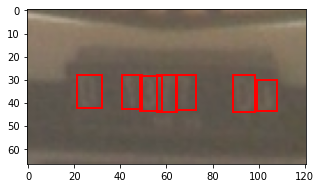

In [9]:
def plot_img_bbox(img, target):
    # plot the image and bboxes
    # Bounding boxes are defined as follows: x-min y-min width height
    fig, a = plt.subplots(1,1)
    fig.set_size_inches(5,5)
    a.imshow(img)
    for box in (target['boxes'].cpu().numpy()):
        print( box[0], box[1], box[2], box[3])
        x, y, width, height  = box[0], box[1], box[2]-box[0], box[3]-box[1]
        rect = patches.Rectangle((x, y),
                                 width, height,
                                 linewidth = 2,
                                 edgecolor = 'r',
                                 facecolor = 'none')

        # Draw the bounding box on top of the image
        a.add_patch(rect)
        
    plt.show()
plot_img_bbox(image_ori, probs)